In [2]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import rioxarray as rxr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
night_fp = "/Users/riainfitzsimons/Desktop/brooklyn_museum_geo/data/raw_data/LandScan/LandScanConusNight.tif"

with rasterio.open(night_fp) as src:
    print(src.profile)        # driver, dtype, CRS, transform, #bands, etc.
    night = src.read(1, masked=True)   # read band 1 as a masked array


{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 69900, 'height': 30300, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0008333333299999999, 0.0, -125.0,
       0.0, -0.0008333333299999999, 49.499999899), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}


Text(0.5, 1.0, 'LandScan Night-Time Population: Manhattan')

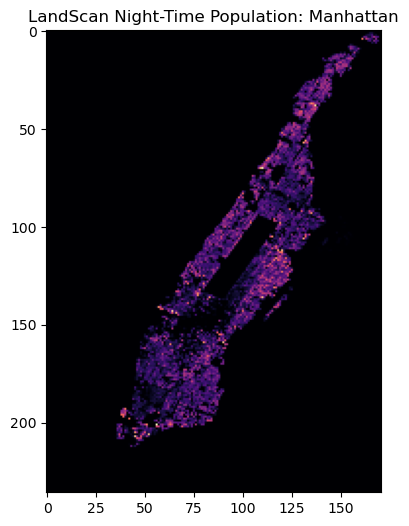

In [3]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt

# 1. Load the NYC borough shapefile
nyc_fp = "/Users/riainfitzsimons/Desktop/brooklyn_museum_geo/data/raw_data/nybb_25a/nybb.shp"
boroughs = gpd.read_file(nyc_fp)

# 2. Filter for Manhattan
manhattan = boroughs[boroughs["BoroName"] == "Manhattan"]

# 3. Open the raster and reproject geometry
night_fp = "/Users/riainfitzsimons/Desktop/brooklyn_museum_geo/data/raw_data/LandScan/LandScanConusNight.tif"

with rasterio.open(night_fp) as src:
    manhattan_proj = manhattan.to_crs(src.crs)

    # 4. Clip the raster to Manhattan
    out_image, out_transform = mask(src, manhattan_proj.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# 5. Plot the result
fig, ax = plt.subplots(figsize=(6,6))
show(out_image, ax=ax, cmap="magma")
ax.set_title("LandScan Night-Time Population: Manhattan")


In [4]:
def clip_and_plot(borough_name):
    # Filter for selected borough
    area = boroughs[boroughs["BoroName"] == borough_name]

    with rasterio.open(night_fp) as src:
        area_proj = area.to_crs(src.crs)
        out_image, out_transform = mask(src, area_proj.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    show(out_image, ax=ax, cmap="magma")
    ax.set_title(f"{borough_name} Night-Time Population")

    # Summary stats
    band = out_image[0]
    print(f"→ {borough_name}")
    print(f"   Total pop: {band.sum():,.0f}")
    print(f"   Mean per pixel: {band.mean():.2f}")
    print(f"   Max pixel: {band.max()}")
    print("")


→ Manhattan
   Total pop: 1,627,543
   Mean per pixel: 40.33
   Max pixel: 1373

→ Bronx
   Total pop: 1,431,563
   Mean per pixel: 44.92
   Max pixel: 1731

→ Brooklyn
   Total pop: 2,582,514
   Mean per pixel: 50.44
   Max pixel: 1488

→ Queens
   Total pop: 2,277,127
   Mean per pixel: 23.10
   Max pixel: 1179

→ Staten Island
   Total pop: 476,095
   Mean per pixel: 10.43
   Max pixel: 476



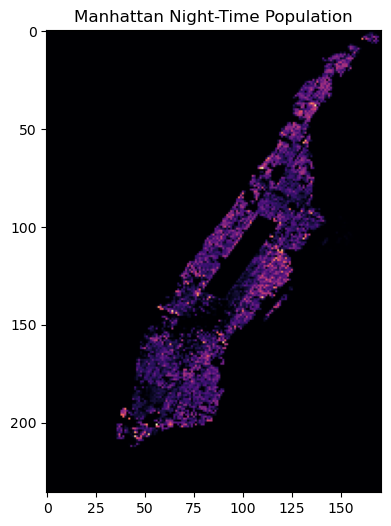

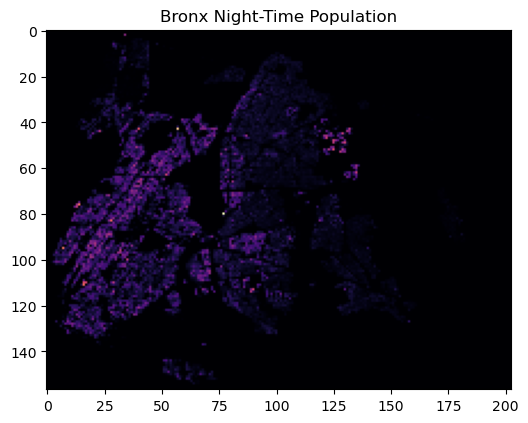

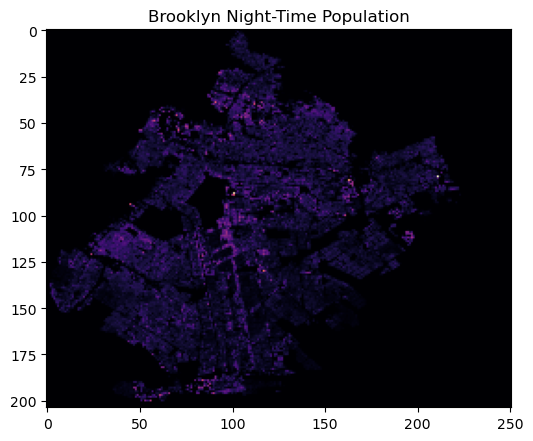

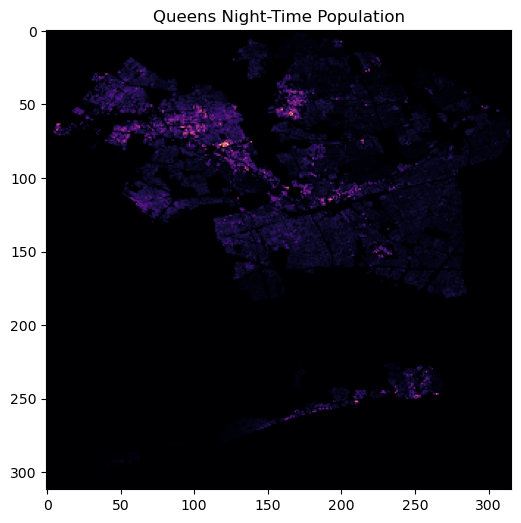

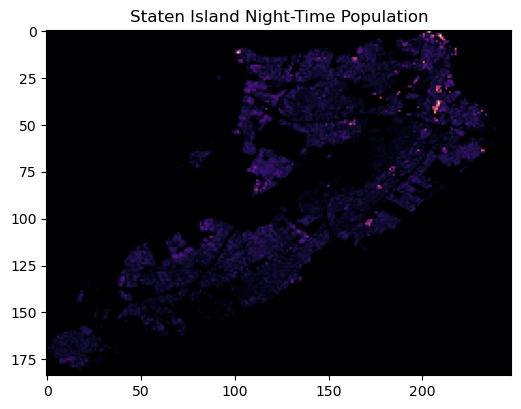

In [5]:
for boro in ["Manhattan", "Bronx", "Brooklyn", "Queens", "Staten Island"]:
    clip_and_plot(boro)